In [3]:
import os
# os.chdir("C:/Users/nikol/Documents/GitHub/GFlowNetsA/GraphClustering")

import torch
from Network import GraphNet
from IRM_generative_torch import IRM_graph, clusterIndex
from IRM_post import Cmatrix_to_array, torch_posterior
import matplotlib.pyplot as plt

Couldn't import from GraphClustering.IRM_post. Adding parent folder to path instead.


The number of nodes is the only parameter with no default, so the graph must be created before the network. Here we create a synthetic graph generated from the stochastic processes we assume formed the graph in the IRM model.

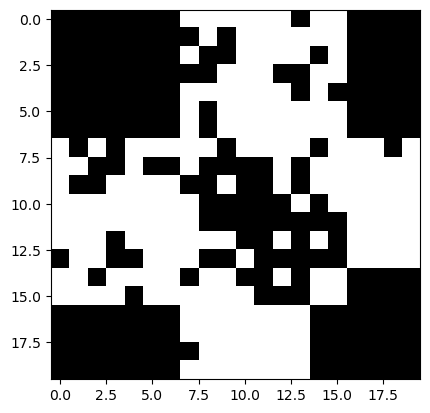

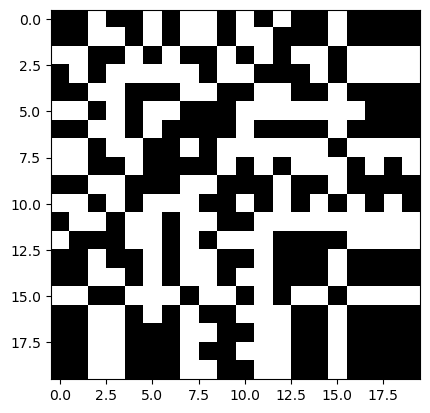

In [4]:
N =  20 
alpha, a, b = 3, 0.5, 0.5
adjacency_matrix, clusters = IRM_graph(alpha = alpha, a = a, b = b, N = 20)
cluster_idxs = clusterIndex(clusters)
# Adjacency_matrix describes the graph. 
# Cluster_idxs is the ground truth and was used to form the graph.
# idxs = torch.random.permutation(torch.arange(N))
idxs = torch.randperm(N, dtype=torch.int64)

A_random = adjacency_matrix[idxs][:, idxs] 
cluster_random = cluster_idxs[idxs]

plt.figure()
plt.imshow(adjacency_matrix, cmap='gray')
plt.show()

plt.figure()
plt.imshow(A_random, cmap='gray')
plt.show()


Network is created as so:

In [5]:
net = GraphNet(n_nodes=adjacency_matrix.size()[0])

The input to the network is a vector of length 2 * (n_nodes ^ 2) + n_nodes. The first n_nodes^2 is the adjacency matrix, the next is the clustering matrix specifying which nodes are in the same cluster and the final n_nodes indicate which node was most recently placed into a cluster.

In [6]:
clustering_list = torch.tensor([1, 1, 2, 3, 0])
clustering_mat = net.get_clustering_matrix(clustering_list, 4)
last_node_placed = torch.zeros(5)
last_node_placed[3] = 1
b = torch.concat((torch.tensor(adjacency_matrix).flatten(), torch.tensor(clustering_mat).flatten(), last_node_placed))

C:\Users\gabri\AppData\Local\Temp\ipykernel_11368\3200748138.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.concat((torch.tensor(adjacency_matrix).flatten(), torch.tensor(clustering_mat).flatten(), last_node_placed))


To train, one must first sample a number of clusterings using sample_forward, which will sample using the current network along with added randomness. The amount of randomness is set using the parameter 'gamma' when instantiating the network. Default is 0.5

In [7]:
X = net.sample_forward(adjacency_matrix=adjacency_matrix)
net.train(X, epochs=10)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\gabri\OneDrive - Danmarks Tekniske Universitet\Lokale Filer\DTU\Forår 2023\Fagprojekt\GFlowNetsA\GraphClustering\Network\Network.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clustering_list[node_chosen] = torch.tensor(cluster_index_chosen + 1, dtype=torch.float32)
100%|██████████| 10/10 [14:54<00:00, 89.43s/it]


Once finished, sampling again will produce different results. If you only want complete clusterings, set the net property 'termination_chance' to 0.

In [8]:
net.termination_chance = 0
X1 = net.sample_forward(adjacency_matrix)

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


These new samples have the same length as the input to the network, so use indexing to get the clustering matrix or use the method of the GraphNet class called get_matrices_from_state

In [9]:
pretrain_clusterings = []
av_post_pretrain = 0
for x in X:
    pretrain_clusterings.append(net.get_matrices_from_state(x)[1])
    av_post_pretrain += torch_posterior(A_random, net.get_clustering_list(pretrain_clusterings[-1])[0],
                                        a=torch.ones(a), b=torch.ones(b), alpha = alpha, log=True) 

posttrain_clusterings = []
av_post_posttrain = 0
for x in X1:
    posttrain_clusterings.append(net.get_matrices_from_state(x)[1])
    av_post_posttrain += torch_posterior(A_random, net.get_clustering_list(posttrain_clusterings[-1])[0],
                                         a=torch.ones(a), b=torch.ones(b), alpha = alpha, log=True) 

print(av_post_pretrain, "should be lower than", av_post_posttrain, "given we sample enough. \n" )


c:\Users\gabri\OneDrive - Danmarks Tekniske Universitet\Lokale Filer\DTU\Forår 2023\Fagprojekt\GFlowNetsA\GraphClustering\Network\..\IRM_post.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C = torch.t_copy(torch.tensor(C_in, dtype=torch.int32))


tensor(-inf, dtype=torch.float64) should be lower than tensor(-163434.1030, dtype=torch.float64) given we sample enough. 



100%|██████████| 1000/1000 [20:31<00:00,  1.23s/it]


(tensor([1., 2., 1., 2., 1., 2., 1., 2., 2., 1., 1., 0., 2., 2., 2., 1., 1., 1.,
        1., 2.]), 3)


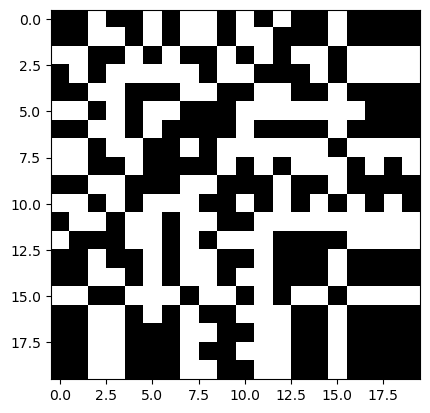

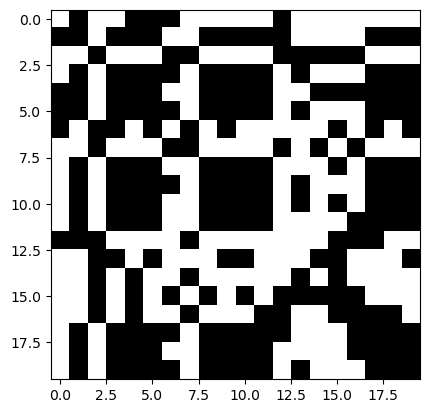

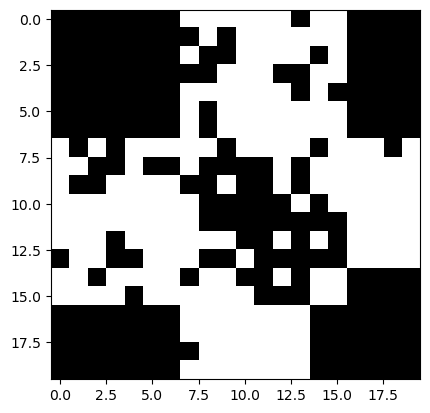

In [10]:
net.termination_chance = 0
X = net.sample_forward(adjacency_matrix=adjacency_matrix)
net.train(X, epochs=10)
X1 = net.sample_forward(adjacency_matrix=adjacency_matrix, epochs= 1000)
posttrain_clusterings = []
posteriors = []
av_post_posttrain = 0

for x in X1:
    posttrain_clusterings.append(net.get_matrices_from_state(x)[1])
    posteriors.append(torch_posterior(A_random, net.get_clustering_list(posttrain_clusterings[-1])[0],
                                         a=torch.ones(a), b=torch.ones(b), alpha = alpha, log=True))
av_post_posttrain = torch.mean(torch.FloatTensor(posteriors)) 
best_clustering = net.get_clustering_list(posttrain_clusterings[torch.argmax(torch.FloatTensor(posteriors))]) 
print(best_clustering)
c_idxs = torch.argsort(best_clustering[0])

plt.figure()
plt.imshow(A_random, cmap='gray')
plt.show()

plt.figure()
plt.imshow(A_random[c_idxs][:, c_idxs], cmap='gray')
plt.show()
print(torch_posterior(A_random, best_clustering, a=torch.ones(a), b=torch.ones(b), alpha = alpha, log=True))

plt.figure()
plt.imshow(adjacency_matrix, cmap='gray')
plt.show()
print(torch_posterior(adjacency_matrix, cluster_idxs, a=torch.ones(a), b=torch.ones(b), alpha = alpha, log=True))
print(torch_posterior(A_random, cluster_random, a=torch.ones(a), b=torch.ones(b), alpha = alpha, log=True))